<a href="https://colab.research.google.com/github/Nourhan-Adell/DeepLearninr_Andrew/blob/main/Logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Logistic regression:**

# **Import packages:**

In [9]:
import copy
import matplotlib.pyplot as plt
import scipy
from PIL import Image   # Python Imaging Library
from scipy import ndimage
import autoreload

%matplotlib inline
#%load_ext autoreload      #autoreload reloads modules automatically before entering the execution of code
#%autoreload 2

# **Load the dataset:**

In [3]:
import numpy as np
import h5py   #is used for images

def load_dataset():
  train_dataset = h5py.File('/content/dataset/train_catvnoncat.h5','r')
  train_set_x_orig = np.array(train_dataset['train_set_x'][:])    # the train set features (get all the data of train_set)
  train_set_y_orig = np.array(train_dataset['train_set_y'][:])    #The train set label
  
  test_dataset = h5py.File('/content/dataset/test_catvnoncat.h5','r')
  test_set_x_orig = np.array(test_dataset['test_set_x'][:]) # The test set features
  test_set_y_orig = np.array(test_dataset['test_set_y'][:]) # The test set labels

  classes = np.array(test_dataset['list_classes'][:]) #The list of classes

  train_set_y_orig = train_set_y_orig.reshape((1,train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [6]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [7]:
print(classes)

[b'non-cat' b'cat']


y = [0] , It is a non-cat picture


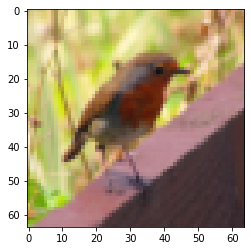

In [15]:
#show example of the pictures
index = 10
plt.imshow(train_set_x_orig[index])
print('y = ' + str(train_set_y[:,index]) + ' , It is a ' + classes[np.squeeze(train_set_y[:, index])].decode('utf-8') + ' picture')

# **Describe the dataset**

In [16]:
number_taining_set = train_set_x_orig.shape[0]    #number of rows
number_test_set = test_set_x_orig.shape[0]        #number of rows
number_px = test_set_x_orig.shape[1]              #(= height = width of a training image)

print ("Number of training examples: " + str(number_taining_set))
print ("Number of testing examples: " + str(number_test_set))
print ("Height/Width of each image: num_px = " + str(number_px))
print ("Each image is of size: (" + str(number_px) + ", " + str(number_px) + ", 3)")  # 3 is the RGB
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: 209
Number of testing examples: 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [22]:
# Reshape the training and test examples to be a vector 
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
    # It takes place through multiplication process of the pixels of the photo (=64*64*3), and
    # the number of rows is the same, so it will be (209, 12288), then transpose it.
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))


train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [23]:

print ("train_set_x_orig shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_orig shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_orig shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x_orig shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

Let's standardize our dataset.

In [24]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255


<a name='3'></a>
## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="/content/images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

In [26]:
def sigmoid(z):
  s = 1 / (1 + np.exp(-z))
  return s

In [28]:
def initialize_with_zeros(dim):
    w = np.zeros(shape=(dim,1))
    b = 0
    return w,b
"""
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
"""

'\n    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.\n    \n    Argument:\n    dim -- size of the w vector we want (or number of parameters in this case)\n    \n    Returns:\n    w -- initialized vector of shape (dim, 1)\n    b -- initialized scalar (corresponds to the bias) of type float\n'

# **Forward and backward propagation:**

In [29]:
def propagate(w,b,X,Y):
#Implement the cost function and its gradient
  m = X.shape[1]

  #Forward propagation
  A = sigmoid(np.dot(w.T, X) + b)
  cost = (-1/m)*(np.sum(Y * np.log(A) + (1-Y) * np.log(1-A)))

  #Backward propagation:
  dw = (1/m) * np.dot(X, (A-Y).T)
  db = (1/m) * np.sum(A-Y)

  cost = np.squeeze(np.array(cost))

  grads = {'dw': dw, 'db': db }
  return grads,cost

# **Optimization:**
Is to update the parameters using the gradient descent

In [57]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):

    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
                
        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw
        b = b - learning_rate * db
                
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

# **Predict:**

In [63]:
def predict(w, b, X):
  #Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
  m = X.shape[1]
  y_prediction = np.zeros((1,m))    # Compute vector "A" predicting the probabilities of a cat being present in the picture
  w = w.reshape( X.shape[0], 1)

  A = sigmoid(np.dot(w.T, X) + b)
  for i in range(A.shape[1]):
     #Convert probabilities A[0,i] to actual predictions p[0,i]
     if A[0,i] > 0.5:
       y_prediction [0,i] = 1
     else:
       y_prediction[0, i] = 0
  return y_prediction

# **Merge all functions into a Model:**

In [64]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost=False):
  w, b = initialize_with_zeros(X_train.shape[0])
  params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
  w = params['w']
  b = params['b']

  Y_prediction_test = predict(w, b, X_test)
  Y_prediction_train = predict(w, b, X_train)

  if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
  d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
  return d

In [65]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %
